In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.datasets
import torchvision.models as model

In [0]:
BATCH = 128
NUM_EPOCHS = 100

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128))
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(256))
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(512))
        self.fc1 = nn.Sequential(
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5))
        self.fc2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5))
        self.fc3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5))
        self.fc4 = nn.Sequential(
            nn.Linear(1024, 100))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

In [0]:
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

In [7]:
validation_split = .2
shuffle_dataset = True
random_seed= 42

dataset = torchvision.datasets.CIFAR100(root='./', train=True, download=True, transform=transform_train)
# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
trainsampler = SubsetRandomSampler(train_indices)
validsampler = SubsetRandomSampler(val_indices)

trainloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH, 
                                           sampler=trainsampler, num_workers=2)
validloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH,
                                                sampler=validsampler, num_workers=2)

Files already downloaded and verified


In [8]:
testset = torchvision.datasets.CIFAR100(root='./', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, num_workers=2)

Files already downloaded and verified


In [0]:
model = CNN()
model = model.cuda()

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0005)

In [0]:
def train(trainloader, model, criterion, optimizer):

  model.train()

  losses = 0
  total = 0
  correct = 0

  for batch_idx, (inputs, targets) in enumerate(trainloader):
    
    inputs, targets = inputs.cuda(), targets.cuda()
    
    outputs = model(inputs)
    
    loss =  criterion(outputs, targets)

    _, predicted = torch.max(outputs.data, 1)
    
    total += targets.size(0)
    correct += (predicted == targets).sum()
    losses += loss.item()*inputs.size(0)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return (losses / total, 100.0 * correct / total)


In [0]:
def validate(validloader, model, criterion):
  model.eval()

  losses = 0
  total = 0
  correct = 0

  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(validloader):
      inputs, targets = inputs.cuda(), targets.cuda()
      
      outputs = model(inputs)
      loss =  criterion(outputs, targets)

      _, predicted = torch.max(outputs.data, 1)
      
      total += targets.size(0)
      correct += (predicted == targets).sum()
      losses += loss.item()*inputs.size(0)
    

  return (losses / total, 100.0 * correct / total)

In [0]:
def test(testloader, model, criterion):
  model.eval()

  losses = 0
  total = 0
  correct = 0

  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
      inputs, targets = inputs.cuda(), targets.cuda()
      
      outputs = model(inputs)
      loss =  criterion(outputs, targets)

      _, predicted = torch.max(outputs.data, 1)
      
      total += targets.size(0)
      correct += (predicted == targets).sum()
      losses += loss.item()*inputs.size(0)
    

  return (losses / total, 100.0 * correct / total)


In [18]:
def run_model(trainloader, validloader, testloader, model, criterion, optimizer):
  import time
  train_losses = []
  train_accuracy = []

  valid_losses = []
  valid_accuracy = []

  for epoch in range(NUM_EPOCHS):
    st = time.time()
    tlosses, tacc = train(trainloader, model, criterion, optimizer)
    vlosses, vacc = validate(validloader, model, criterion)
    print('Epoch: {}:: train_loss: {}, train_accuracy: {} \n valid_loss: {}, valid_accuracy: {}'.format(
        epoch, tlosses, tacc,
        vlosses, vacc
    ))
    train_losses.append(tlosses)
    train_accuracy.append(tacc)
    valid_losses.append(vlosses)
    valid_accuracy.append(vacc)
    
    en = time.time()
    print("epoch took:", en - st)

  test_loss, test_accuracy = test(testloader, model, criterion)
  print("test loss:", test_loss, "test_accuracy:", test_accuracy)
  return {
      'train' : (train_losses, train_accuracy),
      'val'  : (valid_losses, valid_accuracy),
      'test' : (test_loss, test_accuracy)
  }

result = run_model(trainloader, validloader, testloader, model, criterion, optimizer)


Epoch: 0:: train_loss: 4.153549988555908, train_accuracy: 5.577499866485596 
 valid_loss: 3.7445322036743165, valid_accuracy: 11.239999771118164
epoch took: 15.170132875442505
Epoch: 1:: train_loss: 3.7501780254364014, train_accuracy: 10.69749927520752 
 valid_loss: 3.4017262115478517, valid_accuracy: 16.209999084472656
epoch took: 14.8888521194458
test loss: 3.3871428764343263 test_accuracy: tensor(16.6000, device='cuda:0')


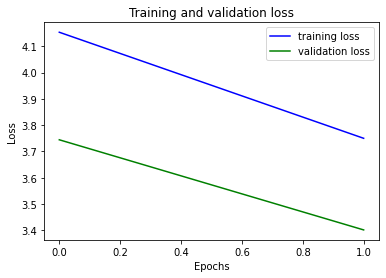

In [19]:
epochs = range(0,NUM_EPOCHS)
plt.plot(epochs, result['train'][0], 'b', label='training loss')
plt.plot(epochs, result['val'][0], 'g', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

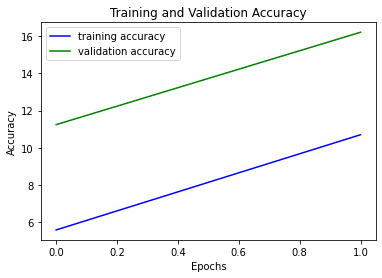

In [20]:
epochs = range(0,NUM_EPOCHS)
plt.plot(epochs, result['train'][1], 'b', label='training accuracy')
plt.plot(epochs, result['val'][1], 'g', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()